<a href="https://colab.research.google.com/github/NewCode321/ES327/blob/main/CNN_tl_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies and Mount Google Drive

In [7]:
# Install Pims and AV
!pip install pims
!pip install av


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import Packages

#general
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import os.path as path # added to make organising directories easier

import glob #required for looping through files in directories

# MediaPipe Functions
mp_drawing = mp.solutions.drawing_utils #function to draw landmarks
mp_drawing_styles = mp.solutions.drawing_styles 
mp_hands = mp.solutions.hands #hand points
mp_face_mesh = mp.solutions.face_mesh #face points

# for MHIs
import scipy
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import cm #colourmaps
from mpl_toolkits.mplot3d import Axes3D 
from skimage import draw as drw
from skimage import color, img_as_float, morphology
import skimage
import pims
from IPython.display import Image

#for NN Transfer Learning
import matplotlib.pylab as pltlab

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator# try using this! 
from tensorflow.keras.utils import to_categorical
from keras import callbacks

import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


TF version: 2.11.0
Hub version: 0.13.0
GPU is available


In [3]:
# mounting google drive to colab to access dataset

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# CNN (transfer learning, inception-resnet base) trained for 3 classes

- tutorial source: https://www.tensorflow.org/tutorials/load_data/images
- tutorial source: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=w_YKX2Qnfg6x

## Install Base Model for transfer learning 

In [8]:
#can pick from a selection of models - tried inception_v3 initially

model_name = "inception_resnet_v2" 

model_handle_map = {
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/5",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",#this one is the final to use
}

model_image_size_map = {
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 # a smaller batch size causes the model to generalise better



Selected model: inception_resnet_v2 : https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Input size (299, 299)


## Load Data
- uses mhis_joined

In [9]:
data_dir = '/content/gdrive/MyDrive/mhis_joined' #main directory

In [14]:
#source:

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.40,
      subset=subset,
      label_mode="categorical",
      # Seed when splitting and randomly shuffling data so that the validation set is stable across runs
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
  
# build preprocessing model
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
  
#training dataset
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

#testing dataset
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 51 files belonging to 3 classes.
Using 31 files for training.
Found 51 files belonging to 3 classes.
Using 20 files for validation.


In [ ]:
train_size

41

## Build the Model

In [15]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)), # define input shape
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
_________________________________________________________________


## Train the Model

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [17]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds).history


Epoch 1/10
1/1 [==============================] - 39s 39s/step - loss: 1.2966 - accuracy: 0.5000 - val_loss: 1.4621 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.7417 - accuracy: 0.4000 - val_loss: 1.3070 - val_accuracy: 0.3500
Epoch 3/10
1/1 [==============================] - 1s 862ms/step - loss: 1.7470 - accuracy: 0.4375 - val_loss: 1.1287 - val_accuracy: 0.4000
Epoch 4/10
1/1 [==============================] - 1s 837ms/step - loss: 1.0282 - accuracy: 0.4667 - val_loss: 1.5121 - val_accuracy: 0.3500
Epoch 5/10
1/1 [==============================] - 1s 880ms/step - loss: 1.1435 - accuracy: 0.5000 - val_loss: 1.6402 - val_accuracy: 0.3500
Epoch 6/10
1/1 [==============================] - 1s 846ms/step - loss: 1.4504 - accuracy: 0.4667 - val_loss: 1.3142 - val_accuracy: 0.4500
Epoch 7/10
1/1 [==============================] - 1s 522ms/step - loss: 0.9971 - accuracy: 0.4375 - val_loss: 1.1425 - val_accuracy: 0.4500
Epoch 8/10
1/1 [========

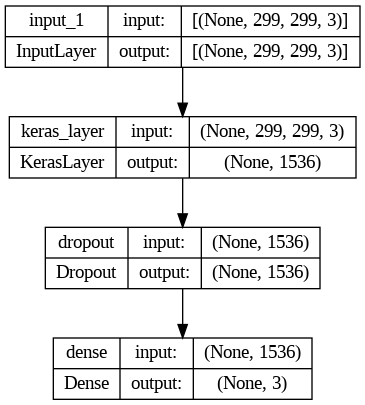

In [ ]:
# Create a diagram of the model architecture

#need to import the function
from keras.utils.vis_utils import plot_model

# save figure to a filepath
# plot_model(model, to_file='/content/gdrive/MyDrive/figures/cnn_tf3_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#check metrics 
print(hist.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Evaluate the Model

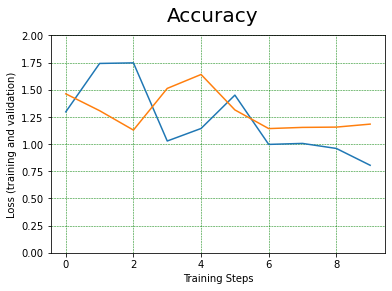

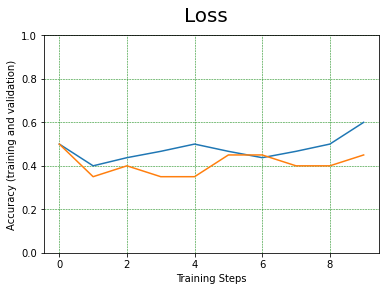

In [18]:
fig = plt.figure()
fig.suptitle('Accuracy', fontsize=20)
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
# plt.savefig('/content/gdrive/MyDrive/figures/trainTL_acc.png')#uncomment to save

fig = plt.figure()
fig.suptitle('Loss', fontsize=20)
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
# plt.savefig('/content/gdrive/MyDrive/figures/trainTL_loss.png')#uncomment to save

# CNN (transfer learning, inception-resnet base) trained for 2 classes

- source: https://www.tensorflow.org/tutorials/load_data/images
- source: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=w_YKX2Qnfg6x

## Install Base Model for transfer learning 

In [ ]:
#source: 

#can pick from a selection of models - tried inception_v3 initially

model_name = "inception_resnet_v2" 

model_handle_map = {
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/5",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",#this one is the final to use
}

model_image_size_map = {
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16 # a smaller batch size causes the model to generalise better



Selected model: inception_resnet_v2 : https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Input size (299, 299)


## Load Data
- uses mhis_joined

In [ ]:
data_dir = '/content/gdrive/MyDrive/mhis_joined_binary' #main directory

In [ ]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.40,
      subset=subset,
      label_mode="categorical",
      # Seed when splitting and randomly shuffling data so that the validation set is stable across runs
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
  
# build preprocessing model
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))#image sizes are fixed when reading, and then a random zoom is applied
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
  
#training dataset
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

#testing dataset
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 29 files belonging to 2 classes.
Using 24 files for training.


Found 29 files belonging to 2 classes.
Using 5 files for validation.


In [ ]:
valid_size

5

In [ ]:
train_size

24

## Build the Model

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)), # define input shape
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


## Train the Model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds).history

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6171 - accuracy: 0.6875 - val_loss: 0.6641 - val_accuracy: 0.8000
Epoch 2/10
1/1 [==============================] - 0s 455ms/step - loss: 0.3415 - accuracy: 1.0000 - val_loss: 0.6622 - val_accuracy: 0.8000
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.6164 - accuracy: 0.7500 - val_loss: 0.6620 - val_accuracy: 0.8000
Epoch 4/10
1/1 [==============================] - 1s 713ms/step - loss: 0.4862 - accuracy: 0.8750 - val_loss: 0.6626 - val_accuracy: 0.8000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.6332 - accuracy: 0.6875 - val_loss: 0.6672 - val_accuracy: 0.8000
Epoch 6/10
1/1 [==============================] - 1s 594ms/step - loss: 0.3250 - accuracy: 0.8750 - val_loss: 0.6779 - val_accuracy: 0.8000
Epoch 7/10
1/1 [==============================] - 1s 984ms/step - loss: 0.6011 - accuracy: 0.6875 - val_loss: 0.7083 - val_accuracy: 0.8000
Epoch 8/10
1/1 [=============

## Evaluate the Model

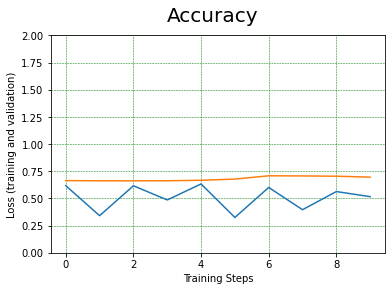

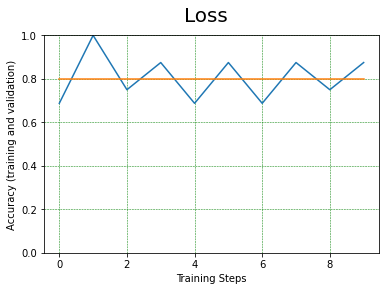

In [ ]:
fig = plt.figure()
fig.suptitle('Accuracy', fontsize=20)
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

fig = plt.figure()
fig.suptitle('Loss', fontsize=20)
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)